In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [3]:
#Load the MNIST dataset
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
#Normalize the images
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
images, labels = next(iter(train_loader))
print(images.shape)
print(images.min(), images.max())

torch.Size([64, 1, 28, 28])
tensor(0.) tensor(1.)


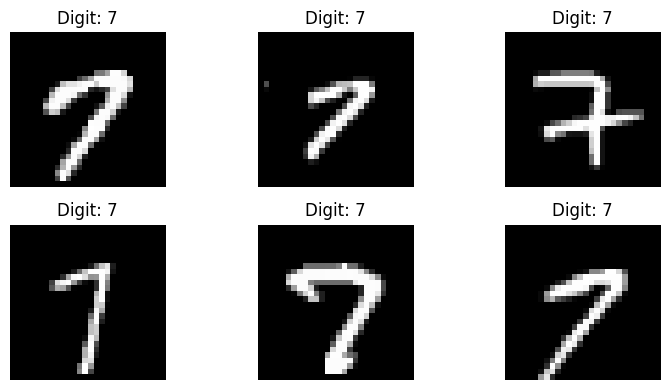

In [10]:
#Pick any one digit (0–9) and display a few example images of that digit from the MNIST dataset.

transform = transforms.ToTensor()
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
target_digit = 7
digit_images = [img for img, label in mnist_dataset if label == target_digit][:6]
plt.figure(figsize=(8, 4))
for i, img in enumerate(digit_images):
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f'Digit: {target_digit}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [16]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Build the CNN
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # 28x28 → 14x14
        x = self.pool(torch.relu(self.conv2(x)))  # 14x14 → 7x7
        x = x.view(-1, 32 * 7 * 7)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)


        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()

    # Evaluate on test set
    model.eval()
    test_loss, test_correct = 0.0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    test_loss /= len(test_loader.dataset)
    train_accuracy = 100 * train_correct / len(train_loader.dataset)
    test_accuracy = 100 * test_correct / len(test_loader.dataset)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Training Loss: {train_loss:.4f}  |  Accuracy: {train_accuracy:.2f}%")
    print(f"  Test Loss:     {test_loss:.4f}  |  Accuracy: {test_accuracy:.2f}%")


Epoch [1/10]
  Training Loss: 0.2164  |  Accuracy: 93.66%
  Test Loss:     0.0705  |  Accuracy: 97.62%
Epoch [2/10]
  Training Loss: 0.0601  |  Accuracy: 98.16%
  Test Loss:     0.0454  |  Accuracy: 98.50%
Epoch [3/10]
  Training Loss: 0.0403  |  Accuracy: 98.75%
  Test Loss:     0.0389  |  Accuracy: 98.70%
Epoch [4/10]
  Training Loss: 0.0324  |  Accuracy: 99.02%
  Test Loss:     0.0323  |  Accuracy: 98.93%
Epoch [5/10]
  Training Loss: 0.0240  |  Accuracy: 99.22%
  Test Loss:     0.0356  |  Accuracy: 98.87%
Epoch [6/10]
  Training Loss: 0.0195  |  Accuracy: 99.33%
  Test Loss:     0.0303  |  Accuracy: 99.00%
Epoch [7/10]
  Training Loss: 0.0147  |  Accuracy: 99.53%
  Test Loss:     0.0262  |  Accuracy: 99.12%
Epoch [8/10]
  Training Loss: 0.0129  |  Accuracy: 99.56%
  Test Loss:     0.0382  |  Accuracy: 98.92%
Epoch [9/10]
  Training Loss: 0.0099  |  Accuracy: 99.68%
  Test Loss:     0.0341  |  Accuracy: 98.98%
Epoch [10/10]
  Training Loss: 0.0083  |  Accuracy: 99.72%
  Test Loss:  

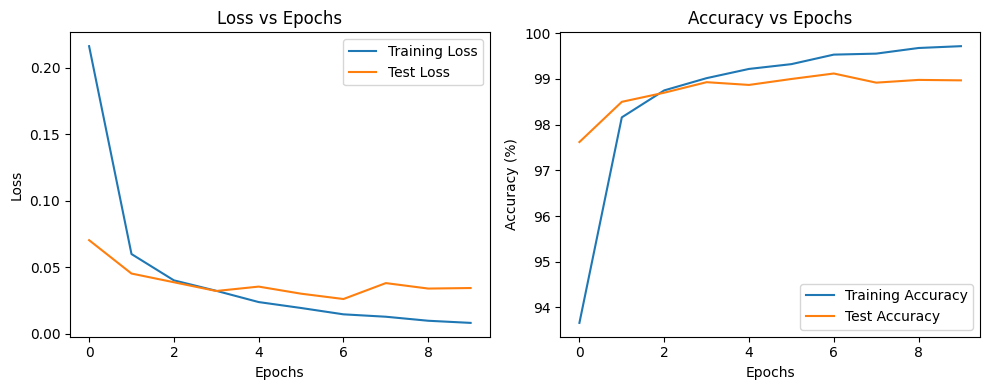

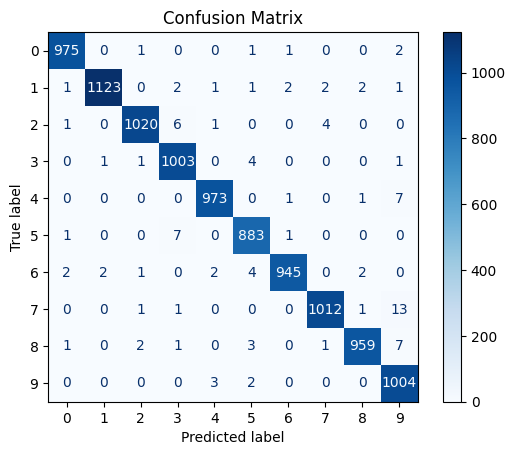

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Training and test loss vs. epochs
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

#Training and test accuracy vs. epochs
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.tight_layout()
plt.show()

#Confusion matrix
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()